# FitCheck - Yoga Pose Feedback Analysis
Uses model statistics (no hardcoded values) + Matplotlib radar chart

## 1. Import Libraries

In [59]:
import os
import pickle
import math
import numpy as np
import cv2
import mediapipe as mp
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from math import pi

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

print(" Libraries imported")

 Libraries imported


## 2. Load Model & Metadata

In [60]:
MODELS_DIR = "models"
MODEL_PATH = os.path.join(MODELS_DIR, "yoga_angle_resnet.pt")
META_PATH = os.path.join(MODELS_DIR, "yoga_angle_resnet_meta.pkl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load metadata with angle statistics
with open(META_PATH, "rb") as f:
    meta = pickle.load(f)

class_names = meta["class_names"]
feature_cols = meta["feature_cols"]
angle_stats = meta["angle_stats"]  # Model statistics
hidden_dim = meta.get("hidden_dim", 256)

print(f"Classes: {class_names}")
print(f"Features: {len(feature_cols)}")
print(f"Poses in angle_stats: {list(angle_stats.keys())}")

Using device: cpu
Classes: ['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior2']
Features: 12
Poses in angle_stats: ['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior2']


## 3. Define Model Architecture

In [61]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
        )
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.net(x) + x)

class AngleResNet(nn.Module):
    def __init__(self, in_dim, num_classes, hidden_dim=256, num_blocks=3, dropout=0.5):
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
        )
        self.blocks = nn.Sequential(*[ResidualBlock(hidden_dim, dropout) for _ in range(num_blocks)])
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        return self.head(self.blocks(self.input_layer(x)))

# Load model
in_dim = len(feature_cols)
num_classes = len(class_names)
model = AngleResNet(in_dim, num_classes, hidden_dim, num_blocks=3, dropout=0.5)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()
print("✓ Model loaded")

✓ Model loaded


## 4. Helper Functions

In [62]:
FRIENDLY_NAMES = {
    "left_hip_angle": "Left Hip", "right_hip_angle": "Right Hip",
    "left_knee_angle": "Left Knee", "right_knee_angle": "Right Knee",
    "left_elbow_angle": "Left Elbow", "right_elbow_angle": "Right Elbow",
    "neck_angle_uk": "Neck",
    "left_shoulder_angle": "Left Shoulder", "right_shoulder_angle": "Right Shoulder",
    "left_wrist_angle_bk": "Left Wrist", "right_wrist_angle_bk": "Right Wrist",
    "hand_angle": "Arms Level",
}

POSE_ANGLE_WHITELIST = {
    "downdog": ["left_knee_angle", "right_knee_angle", "left_hip_angle", "right_hip_angle", 
                "left_shoulder_angle", "right_shoulder_angle", "left_elbow_angle", "right_elbow_angle", "neck_angle_uk"],
    "plank": ["left_hip_angle", "right_hip_angle", "left_knee_angle", "right_knee_angle", 
              "left_elbow_angle", "right_elbow_angle", "left_shoulder_angle", "right_shoulder_angle", "neck_angle_uk"],
    "goddess": ["left_knee_angle", "right_knee_angle", "left_hip_angle", "right_hip_angle",
                "left_shoulder_angle", "right_shoulder_angle", "left_elbow_angle", "right_elbow_angle", "neck_angle_uk"],
    "tree": ["left_hip_angle", "right_hip_angle", "left_knee_angle", "right_knee_angle",
             "left_shoulder_angle", "right_shoulder_angle", "neck_angle_uk"],
    "warrior2": ["left_knee_angle", "right_knee_angle", "left_hip_angle", "right_hip_angle",
                 "left_shoulder_angle", "right_shoulder_angle", "left_elbow_angle", "right_elbow_angle", 
                 "hand_angle", "neck_angle_uk"]
}

def normalize_to_180(angle):
    """Convert 0-360 to 0-180 for display"""
    return 360 - angle if angle > 180 else angle

def circular_diff(a, b):
    """Calculate circular difference"""
    return (a - b + 180) % 360 - 180

def pretty_name(name):
    return FRIENDLY_NAMES.get(name, name.replace("_", " ").title())

def classify_severity(diff, threshold):
    ratio = abs(diff) / max(threshold, 1e-6)
    return "mild" if ratio < 1.2 else "moderate" if ratio < 1.8 else "severe"

def describe_angle_feedback(pose, angle_name, diff, side):
    action = "Decrease" if diff > 0 else "Increase"
    return f"{action} angle of {side} {pretty_name(angle_name)}."

print(" Helper functions defined")

 Helper functions defined


## 5. Angle Calculation

In [63]:
# Calculate angle between 3 landmarks. Returns 0-360 degrees
def calculate_angle(landmark1, landmark2, landmark3):

    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    return angle + 360 if angle < 0 else angle

# Calculate all joint angles
def angles_finder(landmarks):
    
    P = mp_pose.PoseLandmark
    return {
        "left_elbow_angle": calculate_angle(landmarks[P.LEFT_SHOULDER.value], landmarks[P.LEFT_ELBOW.value], landmarks[P.LEFT_WRIST.value]),
        "right_elbow_angle": calculate_angle(landmarks[P.RIGHT_SHOULDER.value], landmarks[P.RIGHT_ELBOW.value], landmarks[P.RIGHT_WRIST.value]),
        "left_shoulder_angle": calculate_angle(landmarks[P.LEFT_ELBOW.value], landmarks[P.LEFT_SHOULDER.value], landmarks[P.LEFT_HIP.value]),
        "right_shoulder_angle": calculate_angle(landmarks[P.RIGHT_HIP.value], landmarks[P.RIGHT_SHOULDER.value], landmarks[P.RIGHT_ELBOW.value]),
        "left_knee_angle": calculate_angle(landmarks[P.LEFT_HIP.value], landmarks[P.LEFT_KNEE.value], landmarks[P.LEFT_ANKLE.value]),
        "right_knee_angle": calculate_angle(landmarks[P.RIGHT_HIP.value], landmarks[P.RIGHT_KNEE.value], landmarks[P.RIGHT_ANKLE.value]),
        "hand_angle": calculate_angle(landmarks[P.LEFT_ELBOW.value], landmarks[P.RIGHT_SHOULDER.value], landmarks[P.RIGHT_ELBOW.value]),
        "left_hip_angle": calculate_angle(landmarks[P.LEFT_SHOULDER.value], landmarks[P.LEFT_HIP.value], landmarks[P.LEFT_KNEE.value]),
        "right_hip_angle": calculate_angle(landmarks[P.RIGHT_SHOULDER.value], landmarks[P.RIGHT_HIP.value], landmarks[P.RIGHT_KNEE.value]),
        "neck_angle_uk": calculate_angle(landmarks[P.NOSE.value], landmarks[P.LEFT_SHOULDER.value], landmarks[P.RIGHT_SHOULDER.value]),
        "left_wrist_angle_bk": calculate_angle(landmarks[P.LEFT_WRIST.value], landmarks[P.LEFT_HIP.value], landmarks[P.LEFT_ANKLE.value]),
        "right_wrist_angle_bk": calculate_angle(landmarks[P.RIGHT_WRIST.value], landmarks[P.RIGHT_HIP.value], landmarks[P.RIGHT_ANKLE.value]),
    }

print(" Angle calculation functions defined")

 Angle calculation functions defined


## 6. Pose Extraction

In [64]:
# Extract pose landmarks from image
def extract_landmarks(image_path):
  
    image = cv2.imread(image_path)
    if image is None:
        return None, None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    with mp_pose.Pose(static_image_mode=True, model_complexity=2, min_detection_confidence=0.5) as pose:
        results = pose.process(image_rgb)
        
        if not results.pose_landmarks:
            return None, image_rgb
        
        h, w, _ = image.shape
        landmarks = [(int(lm.x * w), int(lm.y * h), lm.z * w) for lm in results.pose_landmarks.landmark]
        
        annotated = image.copy()
        mp_drawing.draw_landmarks(annotated, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
        
        return landmarks, annotated

print(" Landmark extraction function defined")

 Landmark extraction function defined


## 7. Matplotlib Radar Chart

In [65]:
# Create radar chart using Matplotlib (based on model statistics)
def create_radar_chart_matplotlib(angle_dict, pose_name, angle_stats, feature_cols):
    
    pose_lower = pose_name.lower()
    
    # Get model statistics
    stats = angle_stats.get(pose_name)
    if not stats:
        for key in angle_stats.keys():
            if key.lower() == pose_lower:
                stats = angle_stats[key]
                break
    
    if not stats:
        return None
    
    mean_angles = stats["mean"]
    whitelist = POSE_ANGLE_WHITELIST.get(pose_lower, [])
    
    # Collect data
    categories = []
    user_values = []
    model_values = []
    
    for i, name in enumerate(feature_cols):
        if name not in whitelist:
            continue
        
        raw_user_val = angle_dict.get(name, 0.0)
        raw_model_mean = mean_angles[i]
        
        display_user_val = normalize_to_180(raw_user_val)
        display_model_val = normalize_to_180(raw_model_mean)
        
        categories.append(pretty_name(name))
        user_values.append(display_user_val)
        model_values.append(display_model_val)
    
    if not categories:
        return None
    
    # Setup polar plot
    num_vars = len(categories)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    user_values_plot = user_values + [user_values[0]]
    model_values_plot = model_values + [model_values[0]]
    angles += angles[:1]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Plot typical form (green)
    ax.plot(angles, model_values_plot, 'o-', linewidth=2.5, label='Typical Form', color='#22c55e', markersize=8)
    ax.fill(angles, model_values_plot, alpha=0.15, color='#22c55e')
    
    # Plot user form (blue)
    ax.plot(angles, user_values_plot, 'o-', linewidth=2.5, label='Your Form', color='#3b82f6', markersize=8)
    ax.fill(angles, user_values_plot, alpha=0.15, color='#3b82f6')
    
    # Configure
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=11, weight='bold')
    ax.set_ylim(0, 180)
    ax.set_yticks([30, 60, 90, 120, 150, 180])
    ax.set_yticklabels(['30°', '60°', '90°', '120°', '150°', '180°'], size=9, color='gray')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.1), fontsize=12, frameon=True, shadow=True)
    
    plt.title(f'Angle Comparison - {pose_name.title()}\nGreen: Typical Form | Blue: Your Form',
              size=15, weight='bold', pad=30)
    plt.tight_layout()
    
    return fig

print(" Radar chart function defined")

 Radar chart function defined


## 8. Feedback Generation

In [66]:
# Generate feedback based on model statistics
def generate_feedback(angle_dict, pose_name, angle_stats, feature_cols, std_factor=1.0, min_deg=20.0):
   
    pose_lower = pose_name.lower()
    
    # angle_stats uses title case: 'Downdog', 'Goddess', etc.
    pose_title = pose_name.title()
    stats = angle_stats.get(pose_title)
    
    # Fallback: try original name
    if not stats:
        stats = angle_stats.get(pose_name)
    
    # Last resort: case-insensitive search
    if not stats:
        for key in angle_stats.keys():
            if key.lower() == pose_lower:
                stats = angle_stats[key]
                break
    
    if not stats:
        return f"Error: No model statistics found for '{pose_name}'. Available: {list(angle_stats.keys())}"

    mean_angles = stats["mean"]
    std_angles = stats["std"]
    
    # POSE_ANGLE_WHITELIST uses lowercase: 'downdog', 'goddess', etc.
    whitelist = POSE_ANGLE_WHITELIST.get(pose_lower, [])
    
    if not whitelist:
        return f"Warning: No whitelist found for '{pose_lower}'. Available: {list(POSE_ANGLE_WHITELIST.keys())}"
    
    correction_lines = []
    correct_lines = []
    
    for i, name in enumerate(feature_cols):
        if name not in whitelist:
            continue
        
        raw_user_val = angle_dict.get(name, 0.0)
        raw_model_mean = mean_angles[i]
        model_std = std_angles[i]
        
        display_user_val = normalize_to_180(raw_user_val)
        display_model_val = normalize_to_180(raw_model_mean)
        
        diff = circular_diff(raw_user_val, raw_model_mean)
        threshold = max(min_deg, std_factor * model_std)
        
        is_correct = abs(diff) <= threshold
        p_name = pretty_name(name)
        severity = classify_severity(diff, threshold)
        side = "left" if "left_" in name else "right" if "right_" in name else ""
        
        if is_correct:
            correct_lines.append(f"  ✅ {p_name}: {display_user_val:.1f}° (Avg: {display_model_val:.1f}°)")
        else:
            text = describe_angle_feedback(pose_lower, name, diff, side)
            correction_lines.append(
                f"  ⚠️ ({severity}) {text} "
                f"({p_name}: {display_user_val:.1f}°, Typical: {display_model_val:.1f}°, Diff: {abs(diff):.1f}°)"
            )
    
    total_checked = len(correct_lines) + len(correction_lines)
    
    if total_checked == 0:
        return f"Warning: No joints checked for '{pose_lower}'. Whitelist: {whitelist}"
    
    score = max(0.0, 100.0 * len(correct_lines) / total_checked)
    
    result = f"\n"
    result += f" Feedback Analysis for {pose_name.title()}\n"
    result += f"\n"
    result += f"Overall Alignment Score: {score:.1f} / 100\n"
    result += f"(Checked {total_checked} joints against model statistics)\n\n"
    
    if correction_lines:
        result += " Corrections Needed:\n" + "\n".join(correction_lines) + "\n\n"
    
    if correct_lines:
        result += "✅ Good Alignment:\n" + "\n".join(correct_lines) + "\n\n"
    
    if not correction_lines and total_checked > 0:
        result += "\n✨ Perfect form! Matches typical expert alignment.\n"
    
    result += f"\n"
    return result

print("✓ Feedback generation function defined")

✓ Feedback generation function defined


## 9. Main Analysis Function

In [67]:
def analyze_image(image_path, std_factor=1.0, min_deg=20.0, show_radar=True):
   
    
    print(f"Analyzing: {image_path}")

    
    # Extract landmarks
    landmarks, annotated_image = extract_landmarks(image_path)
    if landmarks is None:
        print("⚠️ No pose detected")
        return
    print(f"✅ Detected {len(landmarks)} landmarks\n")
    
    # Calculate angles
    angle_dict = angles_finder(landmarks)
    print(f"✅ Calculated {len(angle_dict)} angles\n")
    
    # Predict pose
    feats = [angle_dict.get(name, 0.0) for name in feature_cols]
    x = torch.tensor(feats, dtype=torch.float32, device=device).unsqueeze(0)
    
    with torch.no_grad():
        logits = model(x)
        temperature = 1.5
        scaled_logits = logits / temperature
        probs = torch.softmax(scaled_logits, dim=1)[0].cpu().numpy()
        cls_idx = int(np.argmax(probs))
        pose_name = class_names[cls_idx]
        confidence = probs[cls_idx] * 100
    
    print(f"🧘 Predicted: {pose_name.title()}")
    print(f"Confidence: {confidence:.1f}%\n")
    
    # Generate feedback
    feedback = generate_feedback(angle_dict, pose_name, angle_stats, feature_cols, std_factor, min_deg)
    print(feedback)
    
    # Visualizations
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    axes[0].imshow(annotated_image)
    axes[0].set_title(f"Detected: {pose_name.title()}\nConfidence: {confidence:.1f}%", fontsize=12, weight='bold')
    axes[0].axis('off')
    
    colors = ['#22c55e' if i == cls_idx else '#9ca3af' for i in range(len(probs))]
    axes[1].barh(class_names, probs * 100, color=colors)
    axes[1].set_xlabel('Confidence (%)', fontsize=11, weight='bold')
    axes[1].set_title('Classification Confidence', fontsize=12, weight='bold')
    axes[1].set_xlim(0, 100)
    axes[1].grid(axis='x', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Radar chart
    if show_radar:
        print("\n Generating Radar Chart...")
        radar_fig = create_radar_chart_matplotlib(angle_dict, pose_name, angle_stats, feature_cols)
        if radar_fig:
            plt.show()
            print("✅ Radar chart displayed!")
        else:
            print(" Could not generate radar chart")

print("✓ Main analysis function defined")

✓ Main analysis function defined


## 10. Test Images

Analyzing: test/test1.jpg
✅ Detected 33 landmarks

✅ Calculated 12 angles

🧘 Predicted: Downdog
Confidence: 100.0%


 Feedback Analysis for Downdog

Overall Alignment Score: 100.0 / 100
(Checked 9 joints against model statistics)

✅ Good Alignment:
  ✅ Left Elbow: 177.2° (Avg: 173.7°)
  ✅ Right Elbow: 170.7° (Avg: 176.1°)
  ✅ Left Shoulder: 177.0° (Avg: 177.8°)
  ✅ Right Shoulder: 176.3° (Avg: 177.4°)
  ✅ Left Knee: 172.7° (Avg: 179.2°)
  ✅ Right Knee: 177.9° (Avg: 179.9°)
  ✅ Left Hip: 63.8° (Avg: 144.4°)
  ✅ Right Hip: 65.6° (Avg: 144.8°)
  ✅ Neck: 117.6° (Avg: 161.8°)


✨ Perfect form! Matches typical expert alignment.




I0000 00:00:1764825703.161876 5206138 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1764825703.230619 5208699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764825703.277414 5208699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


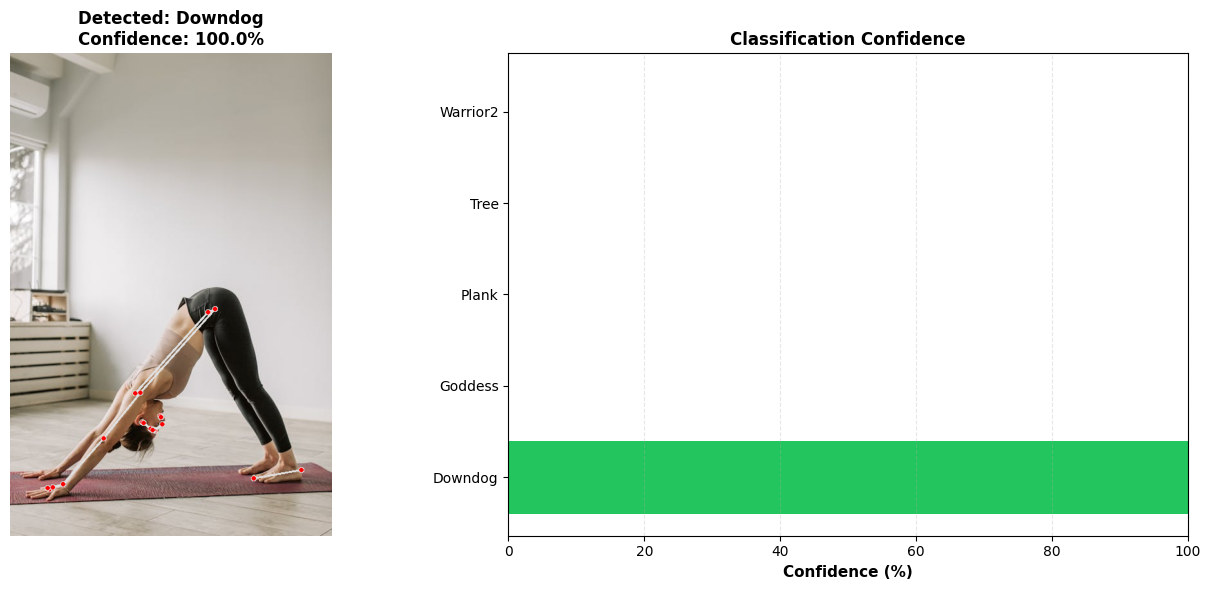


 Generating Radar Chart...


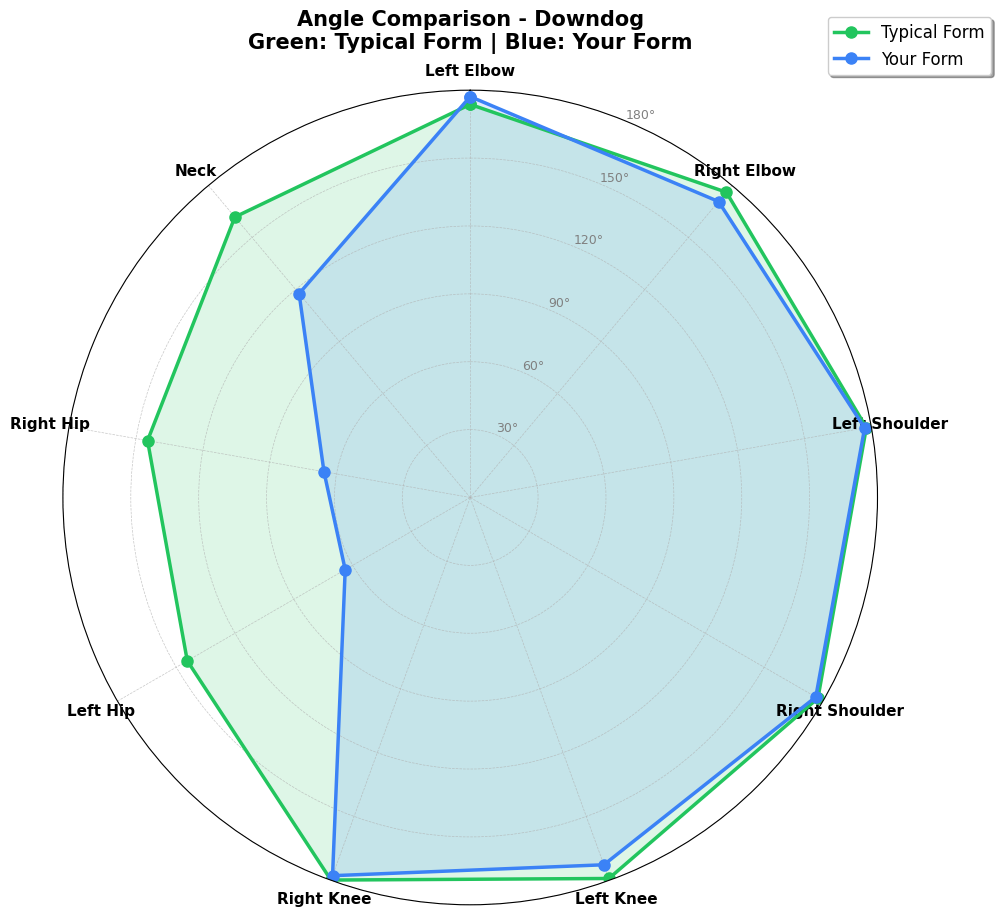

✅ Radar chart displayed!


In [68]:
# Test Image 1
analyze_image("test/test1.jpg", std_factor=1.0, min_deg=20, show_radar=True)

Analyzing: test/test2.jpg


I0000 00:00:1764825703.643046 5206138 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1764825703.714809 5208715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764825703.757522 5208715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


✅ Detected 33 landmarks

✅ Calculated 12 angles

🧘 Predicted: Downdog
Confidence: 100.0%


 Feedback Analysis for Downdog

Overall Alignment Score: 77.8 / 100
(Checked 9 joints against model statistics)

 Corrections Needed:
  ⚠️ (mild) Decrease angle of right Right Elbow. (Right Elbow: 155.4°, Typical: 176.1°, Diff: 20.7°)
  ⚠️ (mild) Decrease angle of right Right Hip. (Right Hip: 51.3°, Typical: 144.8°, Diff: 93.5°)

✅ Good Alignment:
  ✅ Left Elbow: 160.7° (Avg: 173.7°)
  ✅ Left Shoulder: 169.9° (Avg: 177.8°)
  ✅ Right Shoulder: 179.5° (Avg: 177.4°)
  ✅ Left Knee: 178.8° (Avg: 179.2°)
  ✅ Right Knee: 172.2° (Avg: 179.9°)
  ✅ Left Hip: 60.6° (Avg: 144.4°)
  ✅ Neck: 101.6° (Avg: 161.8°)





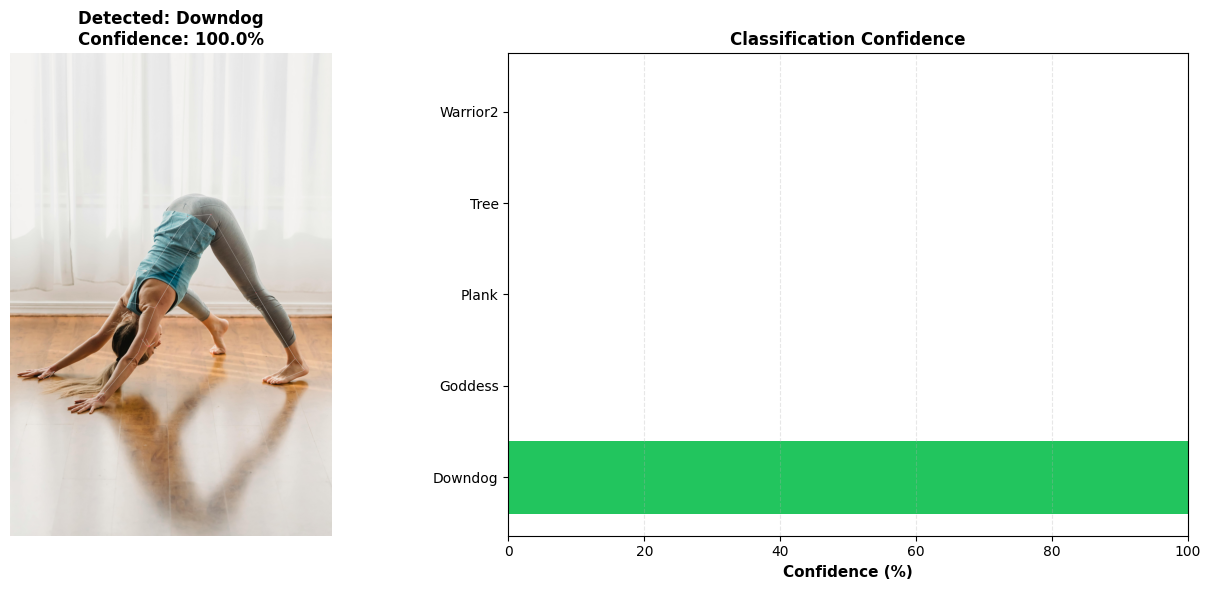


 Generating Radar Chart...


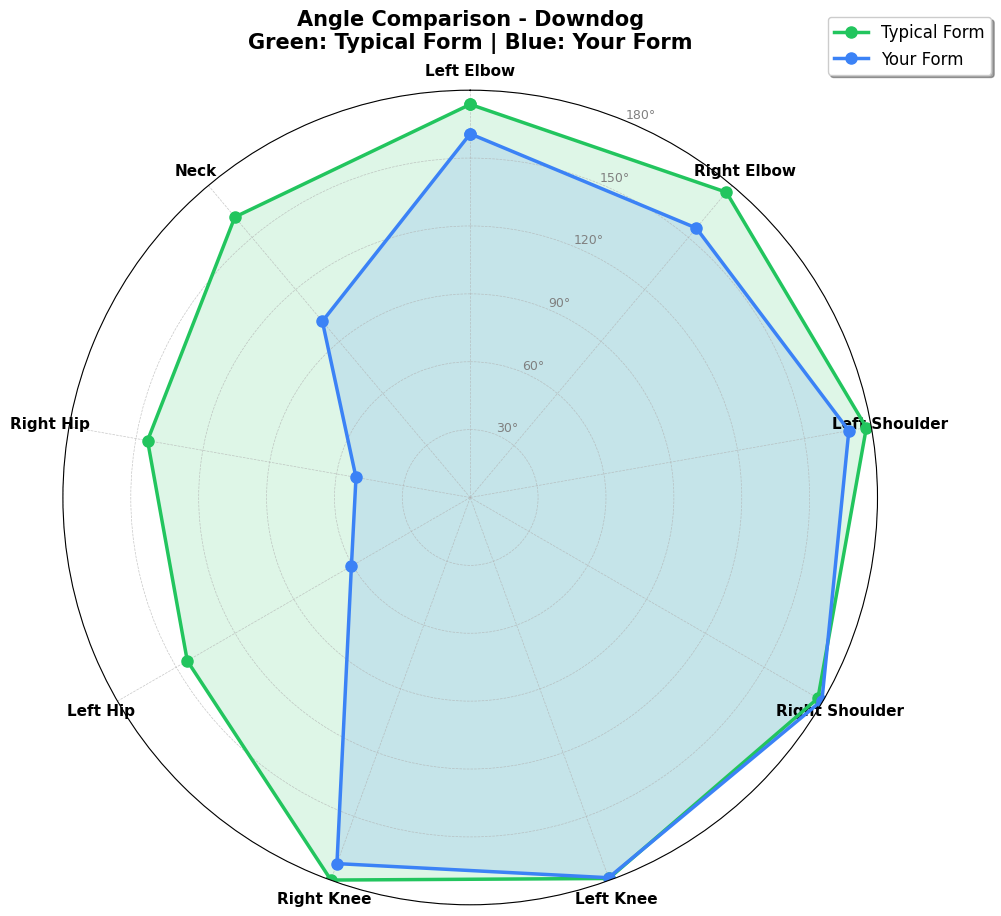

✅ Radar chart displayed!


In [69]:
# Test Image 2
analyze_image("test/test2.jpg", std_factor=1.0, min_deg=20, show_radar=True)

Analyzing: test/test3.jpg
✅ Detected 33 landmarks

✅ Calculated 12 angles

🧘 Predicted: Downdog
Confidence: 100.0%


 Feedback Analysis for Downdog

Overall Alignment Score: 66.7 / 100
(Checked 9 joints against model statistics)

 Corrections Needed:
  ⚠️ (moderate) Increase angle of left Left Knee. (Left Knee: 151.6°, Typical: 179.2°, Diff: 27.6°)
  ⚠️ (moderate) Increase angle of right Right Knee. (Right Knee: 154.6°, Typical: 179.9°, Diff: 25.3°)
  ⚠️ (moderate) Increase angle of  Neck. (Neck: 61.5°, Typical: 161.8°, Diff: 136.7°)

✅ Good Alignment:
  ✅ Left Elbow: 165.4° (Avg: 173.7°)
  ✅ Right Elbow: 167.6° (Avg: 176.1°)
  ✅ Left Shoulder: 178.7° (Avg: 177.8°)
  ✅ Right Shoulder: 178.9° (Avg: 177.4°)
  ✅ Left Hip: 59.9° (Avg: 144.4°)
  ✅ Right Hip: 62.6° (Avg: 144.8°)





I0000 00:00:1764825704.627156 5206138 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1764825704.688499 5208753 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764825704.717542 5208760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


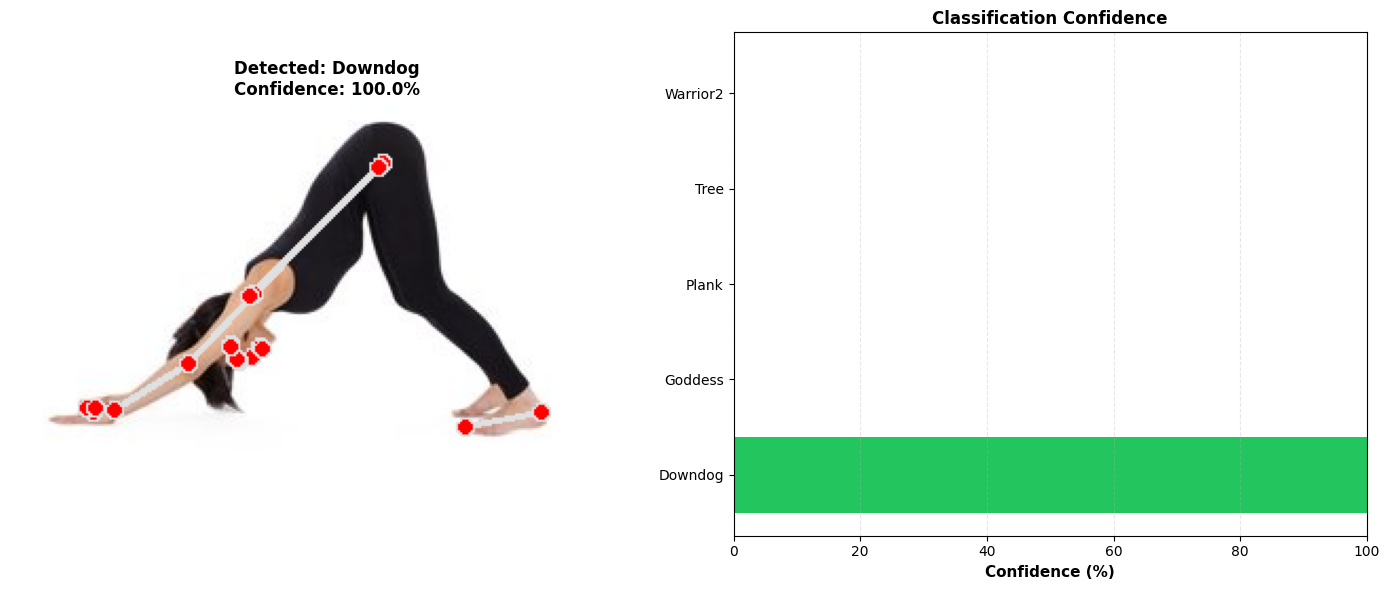


 Generating Radar Chart...


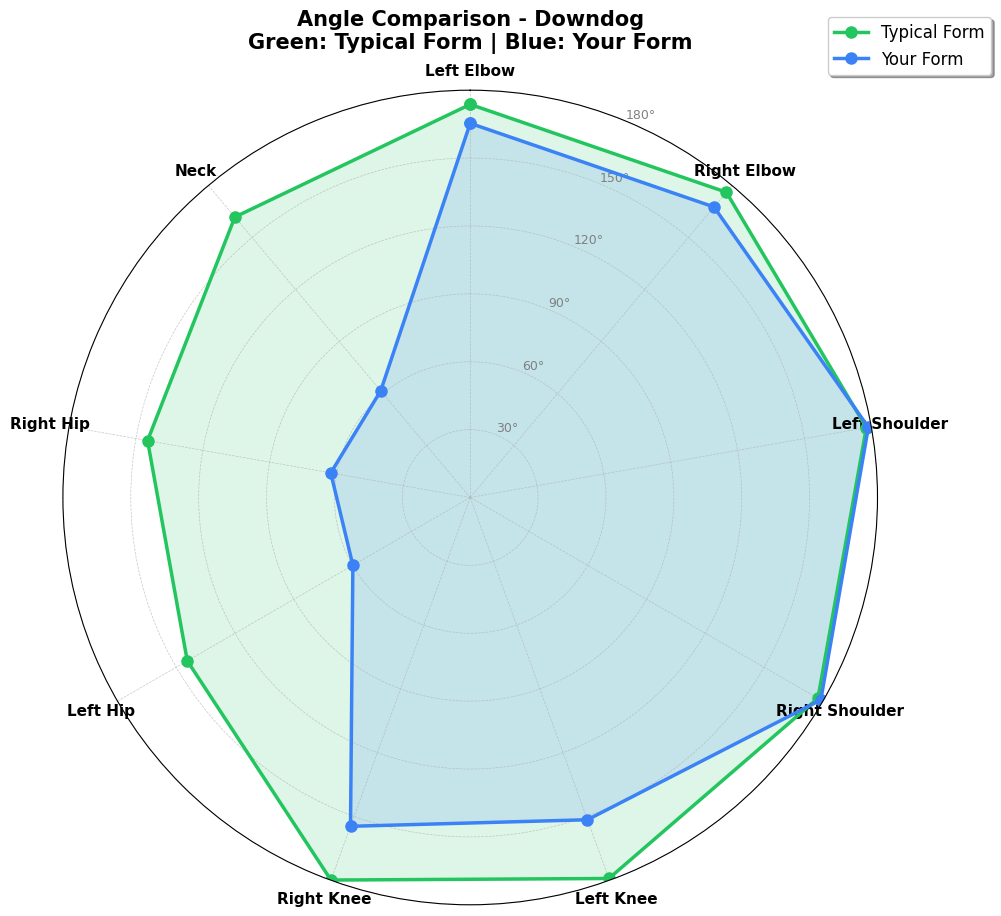

✅ Radar chart displayed!


In [70]:
# Test Image 3
analyze_image("test/test3.jpg", std_factor=1.0, min_deg=20, show_radar=True)